# 2. 時系列データの観察と予約

## 2-1. 時系列データを観察する

4つの会社の株価をプロットしてみる．

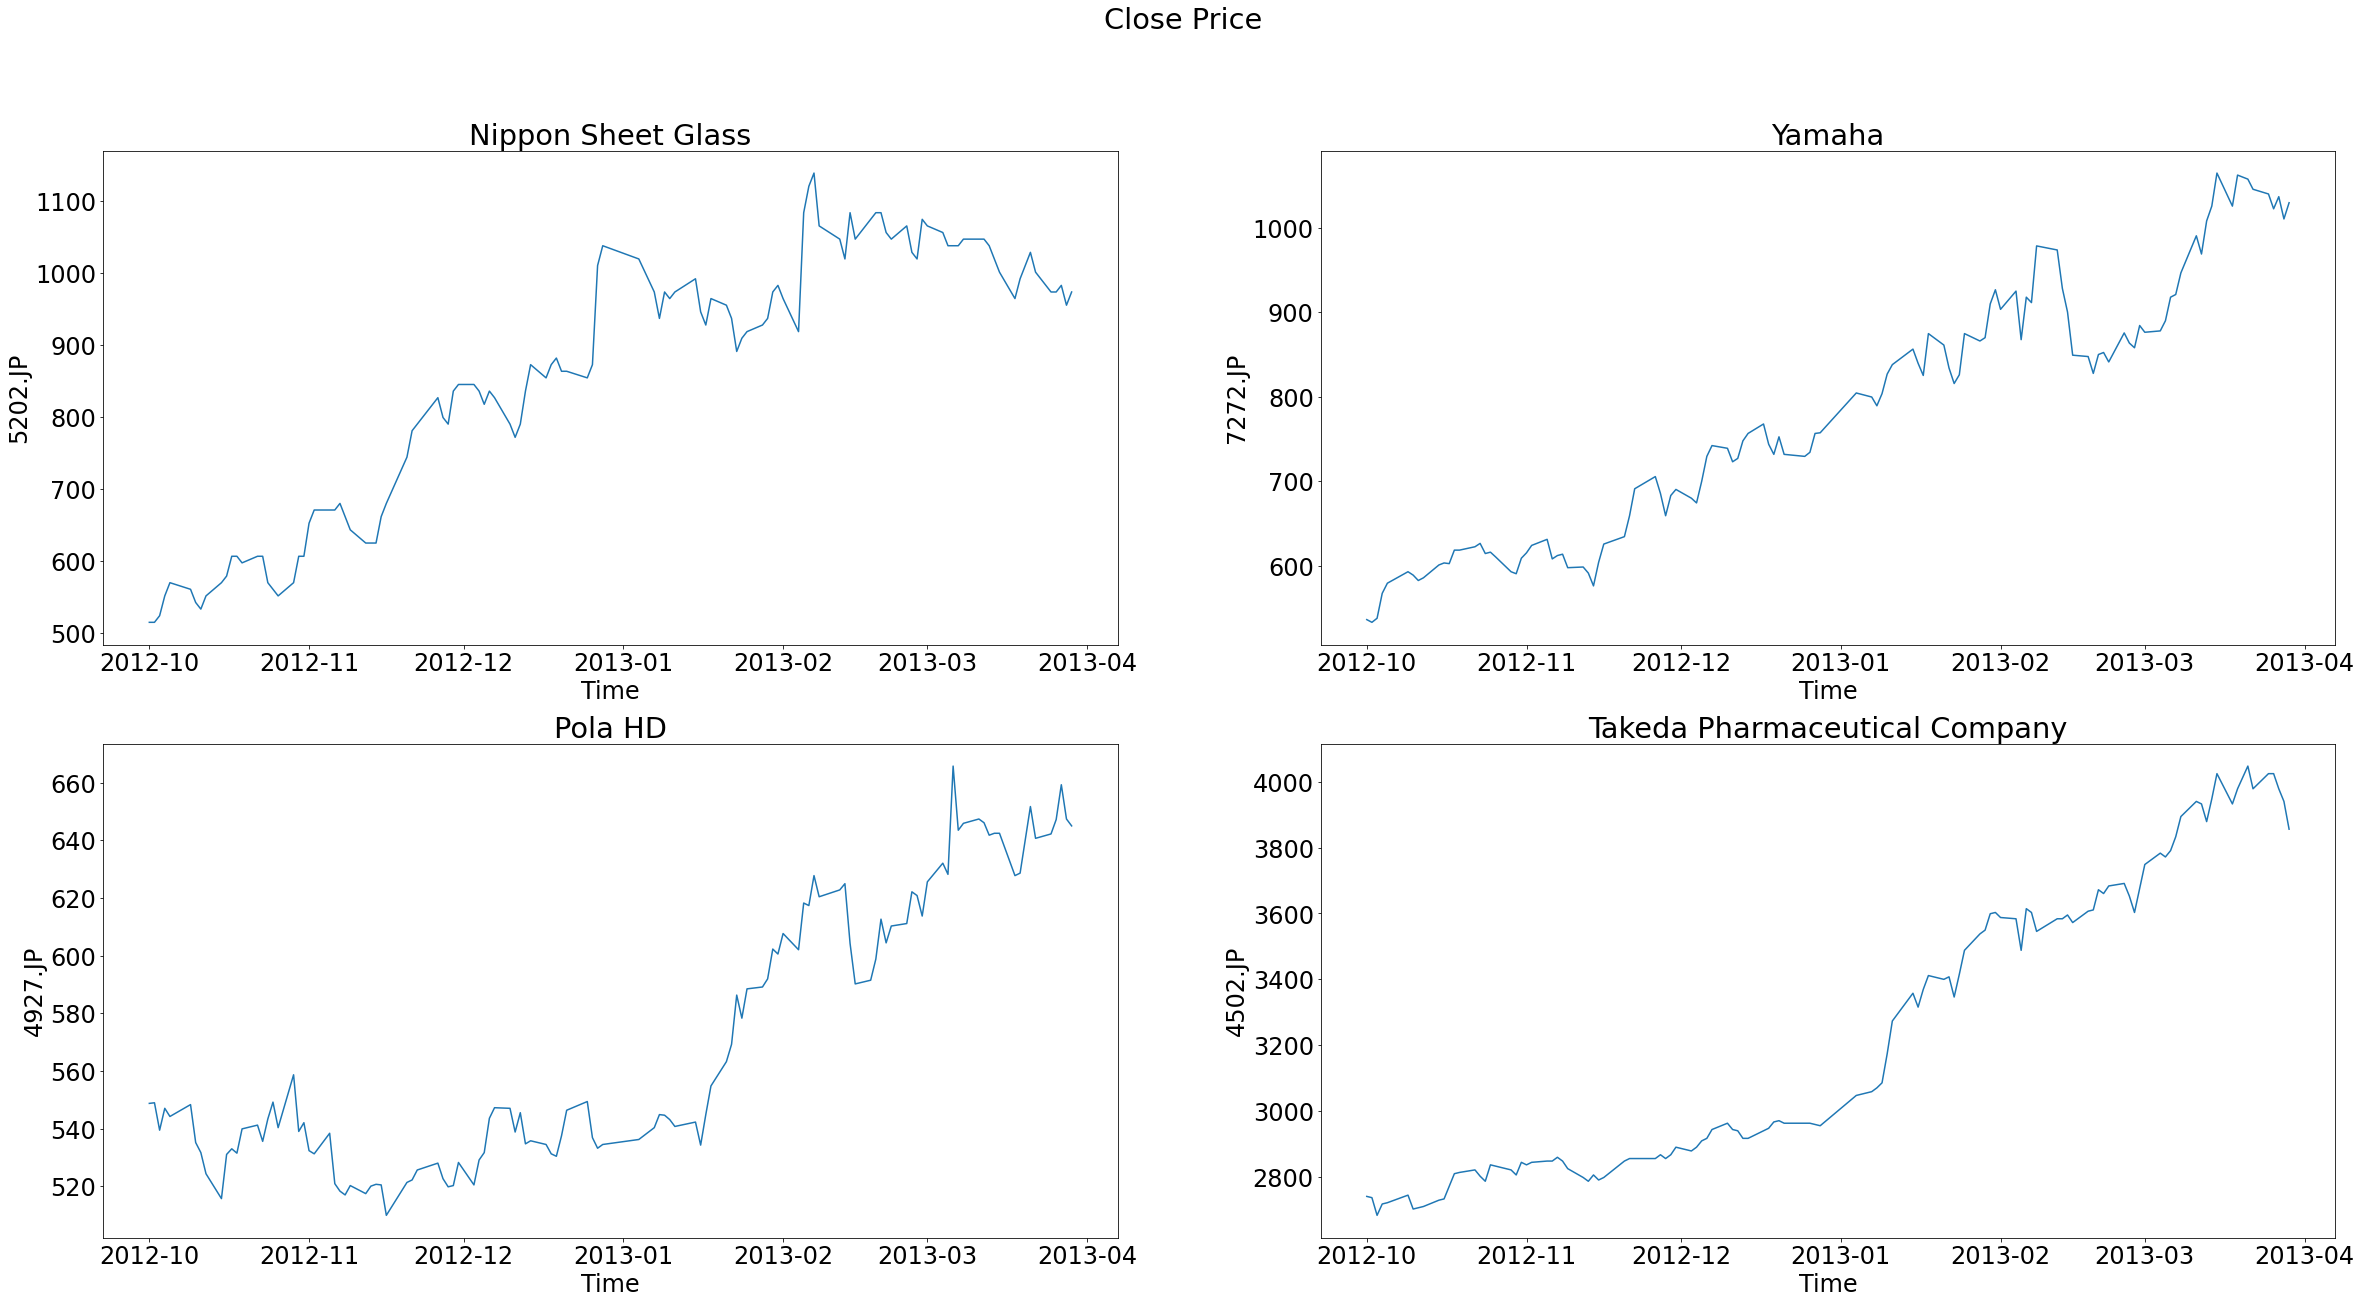

In [2]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import datetime
import numpy as np

plt.rcParams["font.size"] = 24
start = datetime.date(2012, 9, 30)
end = datetime.date(2013, 3, 31)
stocks = [
    {'code':'5202.JP', 'company':'Nippon Sheet Glass'},
    {'code':'7272.JP', 'company':'Yamaha'},
    {'code':'4927.JP', 'company':'Pola HD'},
    {'code':'4502.JP', 'company':'Takeda Pharmaceutical Company'},
]
fig = plt.figure(figsize=(40, 20))
fig.suptitle('Close Price')
for i, s in enumerate(stocks):
    df = pdr.data.DataReader(stocks[i]['code'], 'stooq', start, end).iloc[::-1]
    stocks[i]['data'] = df

for i, s in enumerate(stocks):
    ax = fig.add_subplot(2, 2, i+1)
    df = stocks[i]['data']
    ax.plot(df.index, df['Close'])
    ax.set_title(stocks[i]['company'])
    ax.set_xlabel('Time')
    ax.set_ylabel(stocks[i]['code'])

最初の価格がそれぞれの会社で異なるので，最初の値を1に固定して再度グラフを表示してみる．

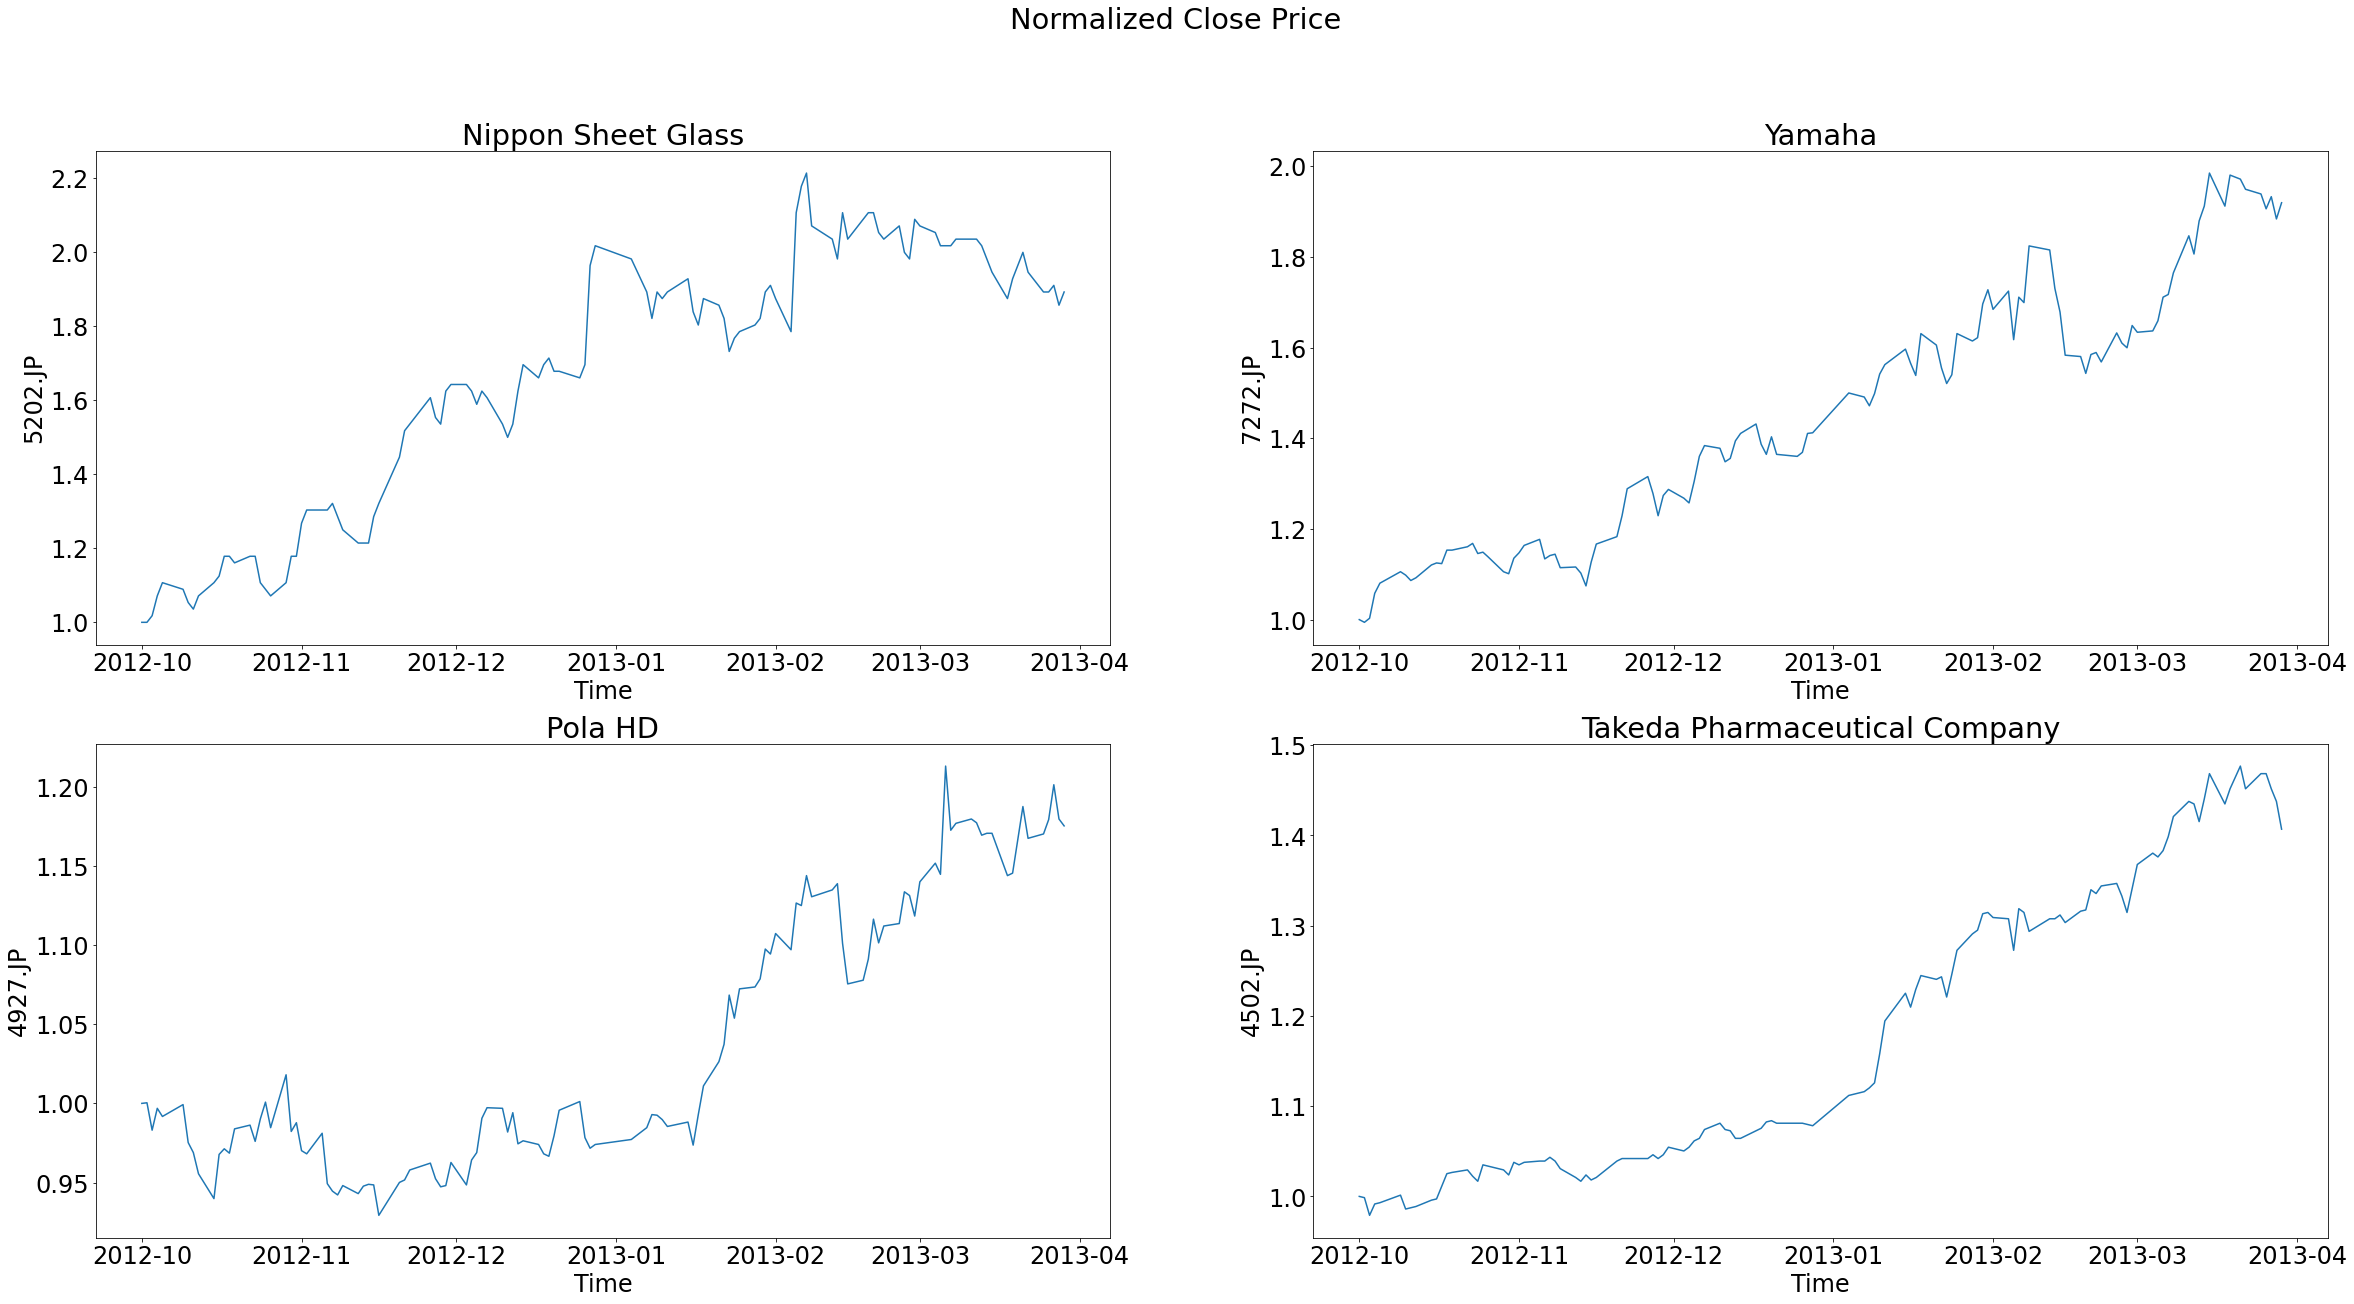

In [3]:
fig = plt.figure(figsize=(40, 20))
fig.suptitle('Normalized Close Price')
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2, 2, i+1)
    df = stocks[i]['data']
    ax.plot(df.index, df['Close']/df['Close'][0])
    ax.set_title(stocks[i]['company'])
    ax.set_xlabel('Time')
    ax.set_ylabel(stocks[i]['code'])

知りたいのは，日々どれくらい変動しているかであるので，それを可視化する．ここでは，対数差収益率を用いる．

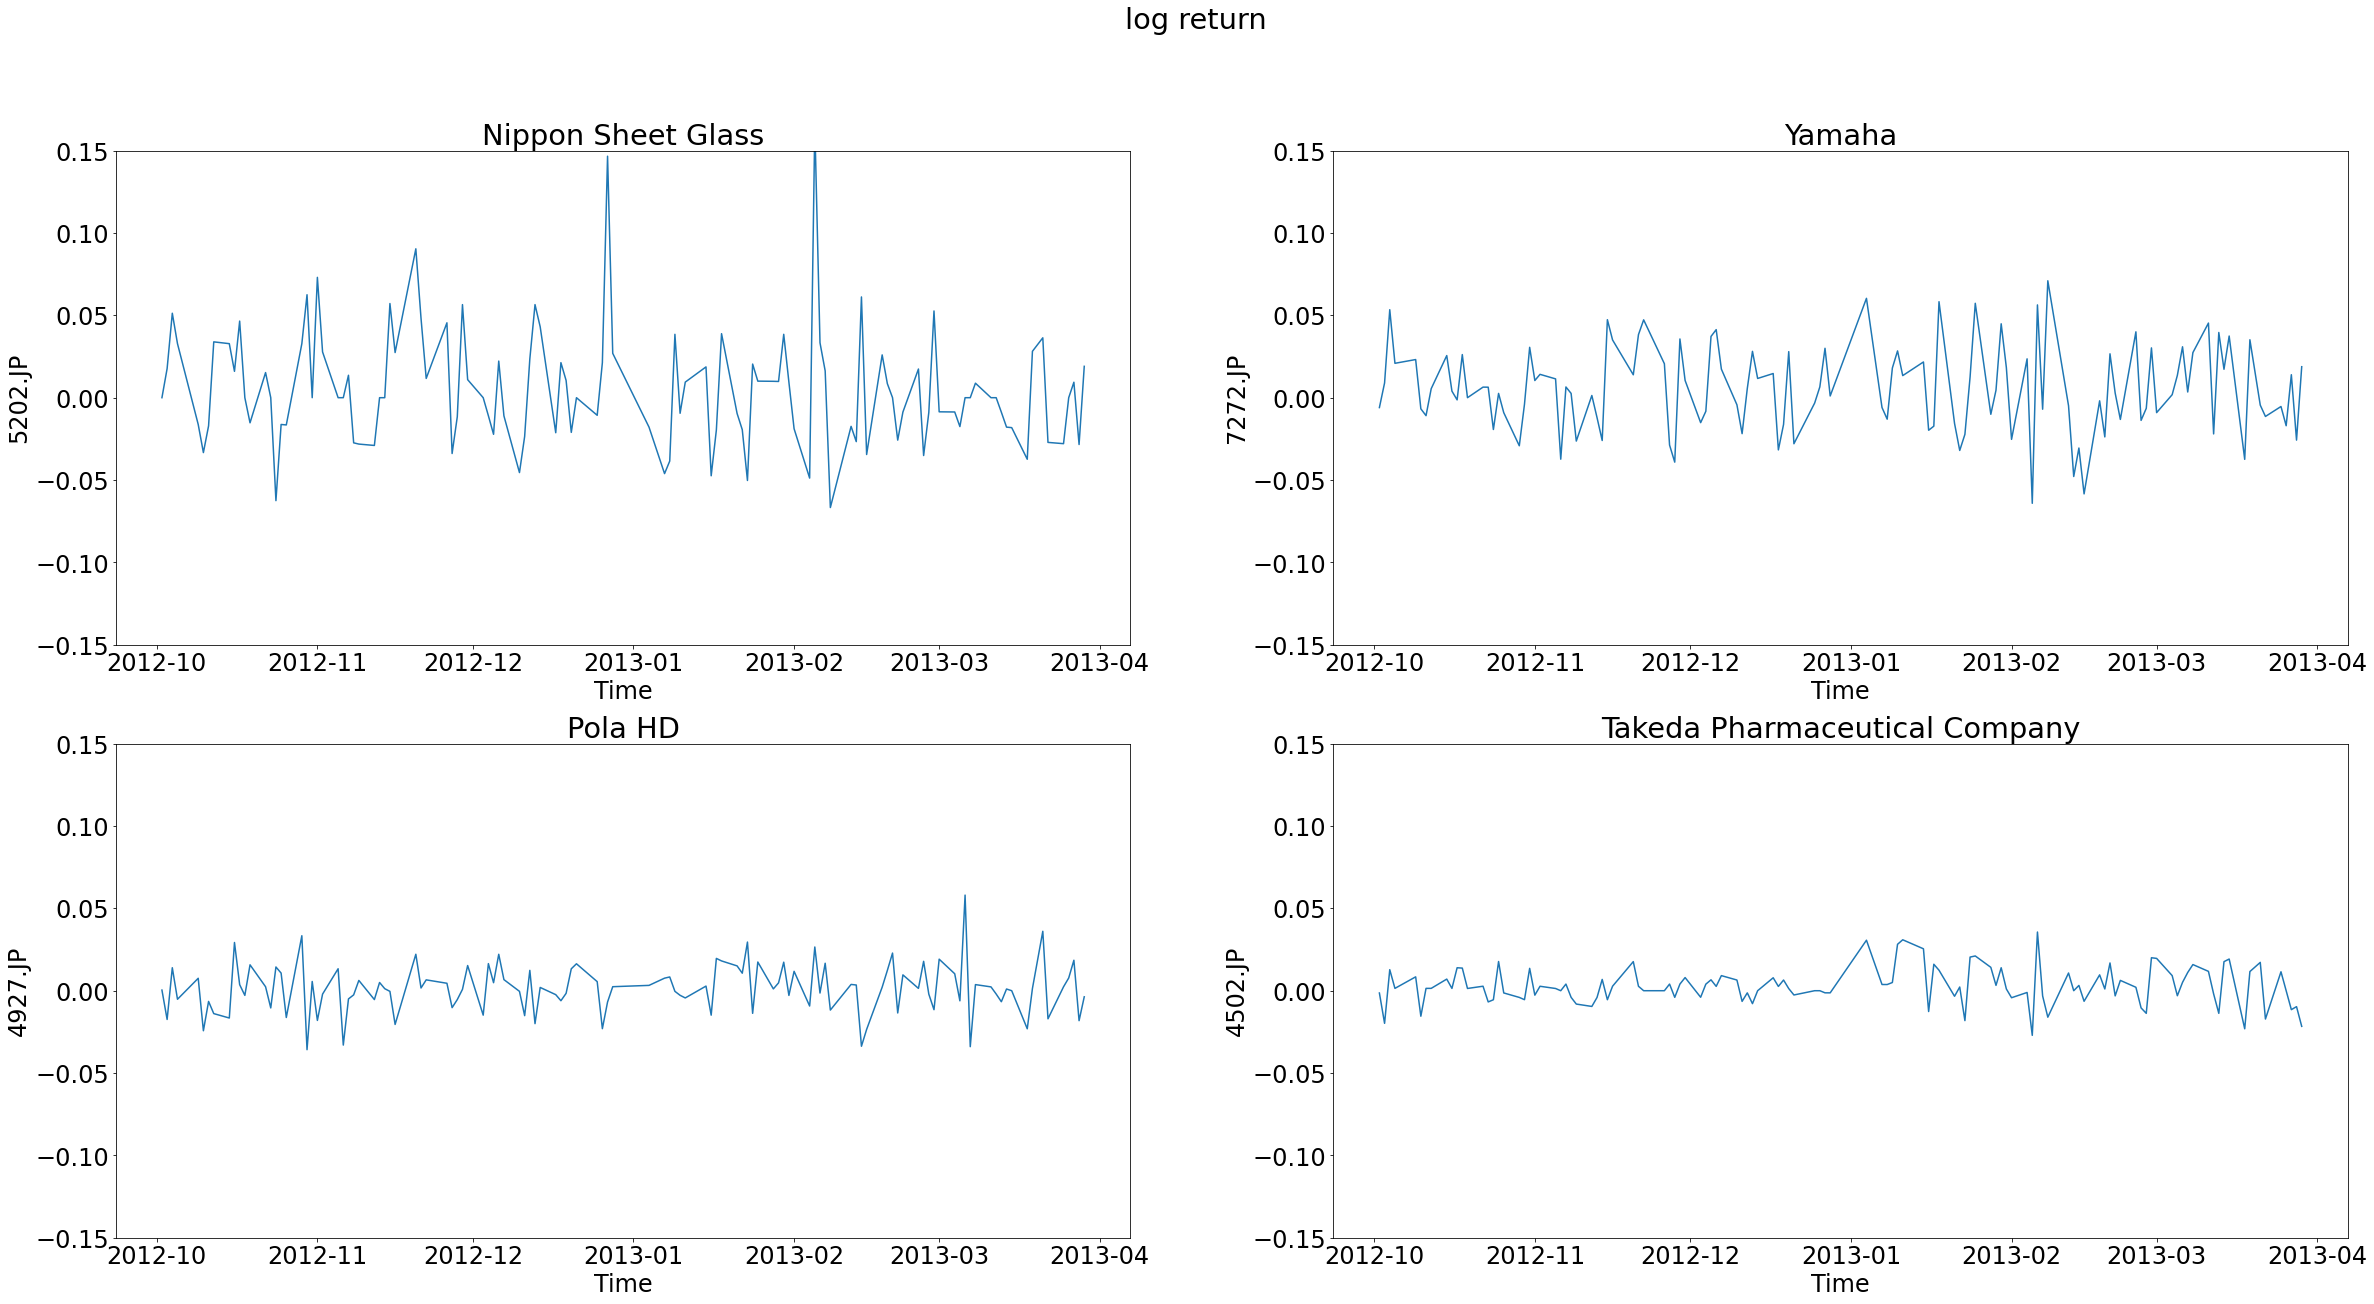

In [4]:
for i, s in enumerate(stocks):
    df = pdr.data.DataReader(stocks[i]['code'], 'stooq', start, end).iloc[::-1]
    stocks[i]['data']['log'] = np.log(stocks[i]['data']['Close'])
    # 対数差収益率
    stocks[i]['data']['log_return'] = stocks[i]['data']['log'].diff() 

fig = plt.figure(figsize=(40, 20))
fig.suptitle('log return')
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2, 2, i+1)
    df = stocks[i]['data']
    # スケールを揃える．
    ax.set_ylim(-0.15, 0.15)
    ax.plot(df.index, df['log_return'])
    ax.set_title(stocks[i]['company'])
    ax.set_xlabel('Time')
    ax.set_ylabel(stocks[i]['code'])

上図は，前日との変動がどれくらい大きいかを表している．日本板硝子は変動が大きく，ボラタイル（ボラティリティが大きい）ということが視覚的に理解できる．一方で，武田薬品やポーラHDはボラティリティが比較的小さいことがわかる．

## 2-2 時系列データの分布と要約



In [7]:
print('mean')
for s in stocks:
    print("{}:\t{}".format(s['company'], s['data']['log_return'].mean()))

mean
Nippon Sheet Glass:	0.005407417758852227
Yamaha:	0.005526464105086142
Pola HD:	0.001369159658447328
Takeda Pharmaceutical Company:	0.0028937110647454054


In [8]:
print('volatility')
for s in stocks:
    print("{}:\t\t\t{}".format(s['company'], s['data']['log_return'].std()))

volatility
Nippon Sheet Glass:			0.03593917905856725
Yamaha:			0.026510202642561626
Pola HD:			0.015280987621604245
Takeda Pharmaceutical Company:			0.01142352257163788


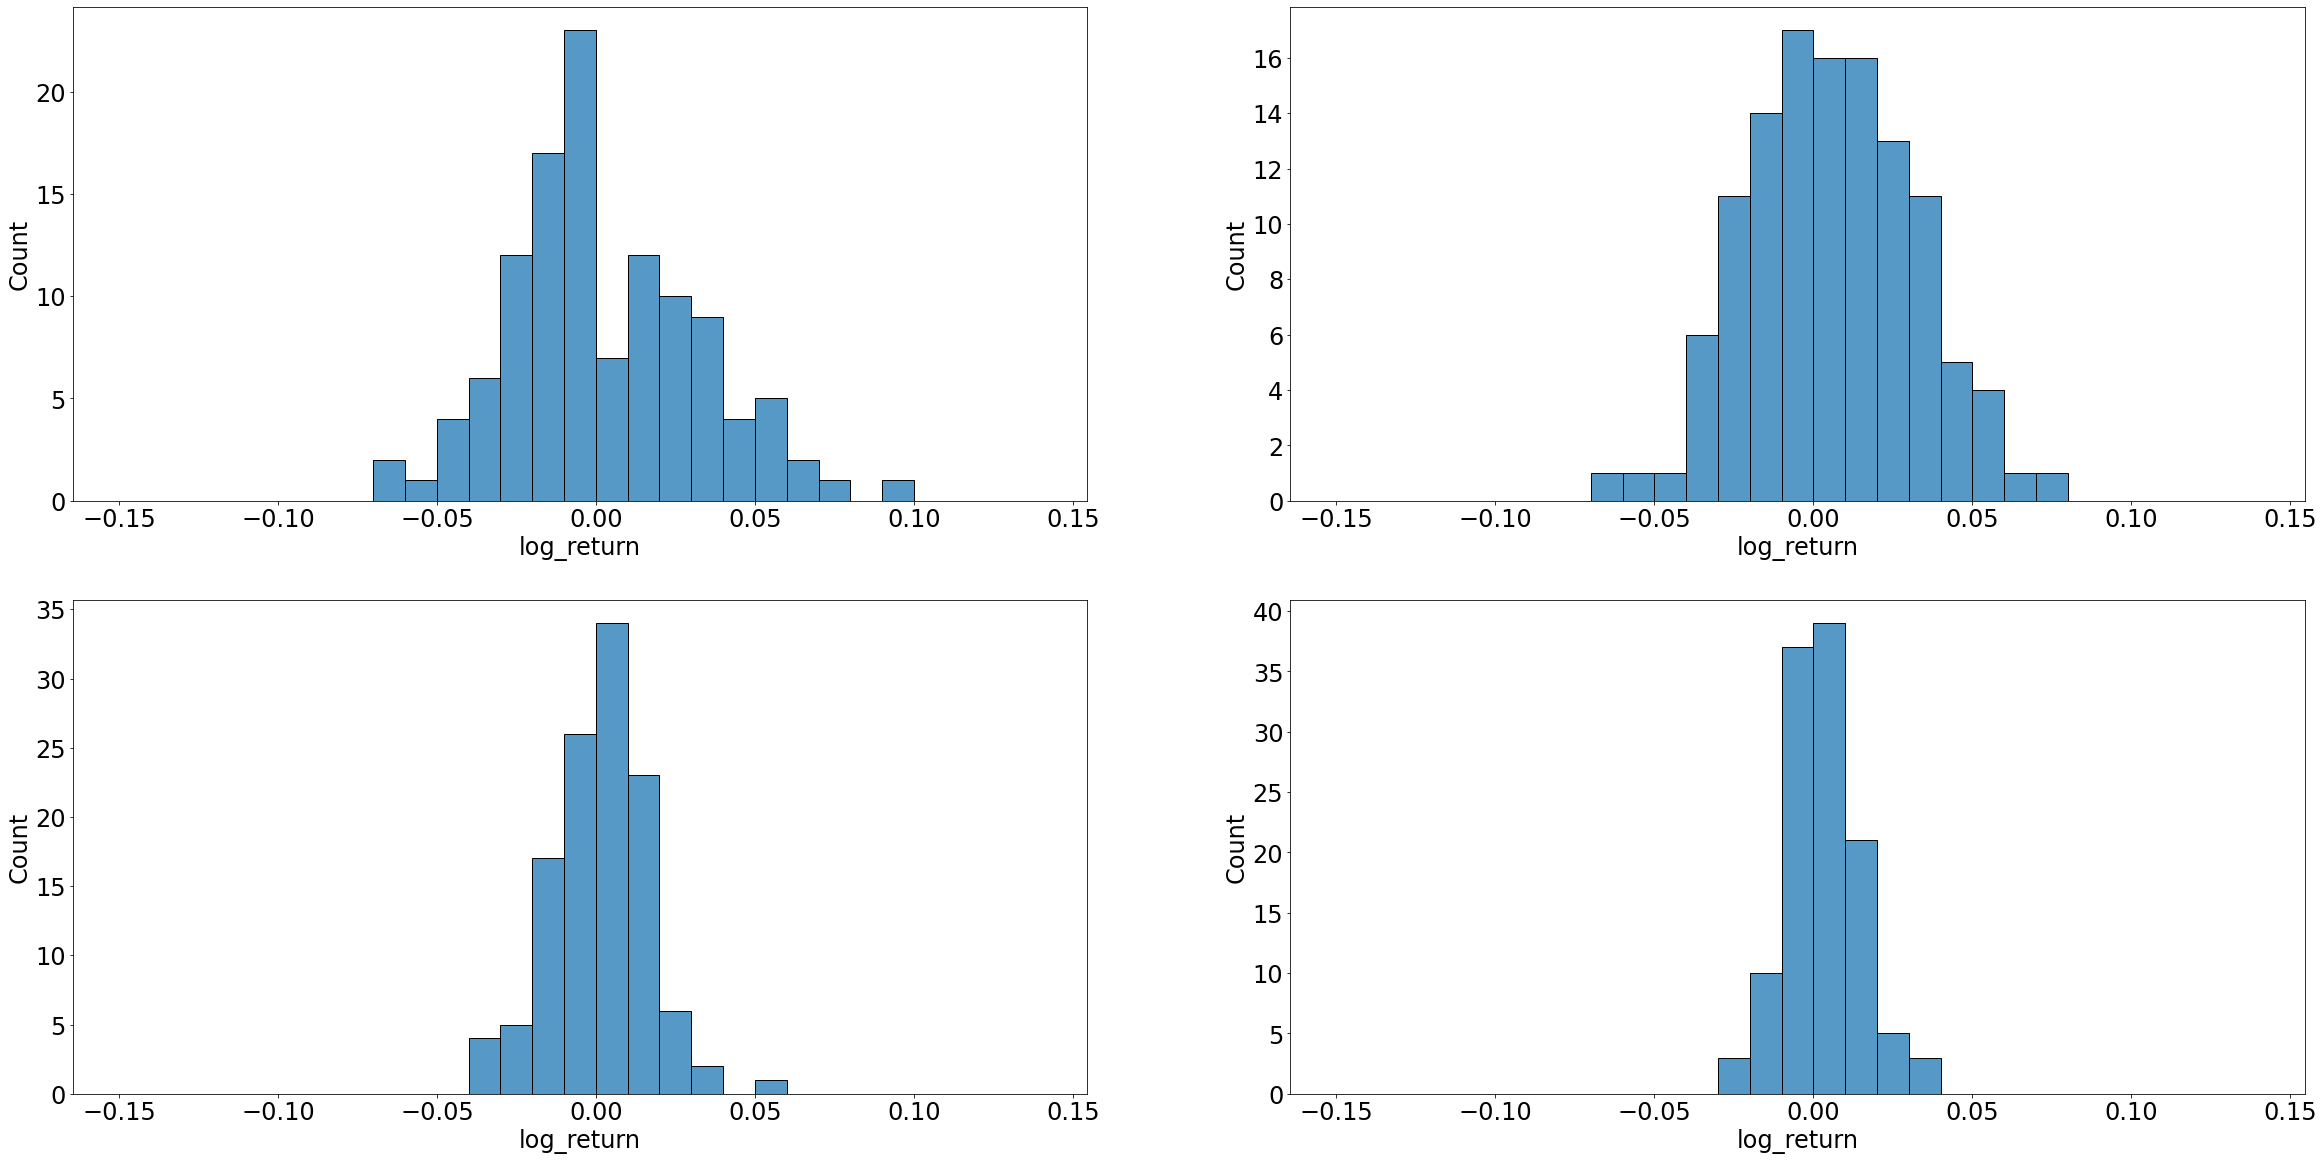

In [14]:
import seaborn as sns

fig = plt.figure(figsize=(40,20))
bins = np.arange(-0.15, 0.15, 0.01)
for i, s in enumerate(stocks):
    ax = fig.add_subplot(2,2,i+1)
    sns.histplot(s['data'], x='log_return', bins=bins, ax=ax)

<AxesSubplot:xlabel='log_return', ylabel='log_return'>

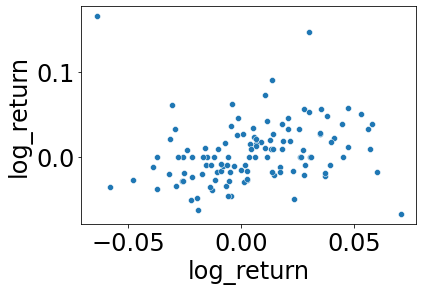

In [17]:
sns.scatterplot(x=stocks[1]['data']['log_return'], y=stocks[0]['data']['log_return'])

In [21]:
stocks[1]['data']['log_return'].corr(stocks[0]['data']['log_return'])

0.19785574597989444

## 2-3 統計的仮説検定について

統計的仮説検定に基づいて，正規分布しているかどうかを客観的に判断する．

Shapiro-Wilk検定を用いると，p値が有意水準以下の時には帰無仮説(正規分布である)が棄却され，正規分布ではないという仮説が受容される．

In [28]:
import scipy 
for i, s in enumerate(stocks):
    print("{}:\t{}".format(s['company'], scipy.stats.shapiro(s['data']['log_return'].dropna()).pvalue))

Nippon Sheet Glass:	5.10930476593785e-06
Yamaha:	0.968437135219574
Pola HD:	0.11247304081916809
Takeda Pharmaceutical Company:	0.23401157557964325


数列に規則性があるかどうかを調べる方法として，連の検定が存在する．ここでは，収益率が正か負のどちらかに対して連の検定を行い，規則性を確かめる．

In [30]:
# pythonでの連の検定がめんどくさそうなのでスキップ
for i, s in enumerate(stocks):
    s['data']['return_pm'] = np.where(s['data']['log_return']>np.mean(s['data']['log_return']), 1, -1)

## 2-4 時間依存の発見

株価の場合，上昇し続けたり下降し続けたりなど，一定の傾向が見られることがある．そうすると，各点でのデータは独立に抽出されたデータというよりも，むしろ「ある傾向に従って抽出された標本」であると考えるのが自然である．詳細は次章で学んでいくことになる．